In [1]:
import numpy as np 
import pandas as pd
import torch
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from pathlib import Path
from os.path import dirname, abspath
import seaborn as sns

In [2]:
#Altered to work on cluster ?
os.chdir("/datasets" + "/MaskedFace-Net")

In [3]:
transform_train = transforms.Compose(
    [transforms.Resize((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
transform_val = transforms.Compose(
    [transforms.Resize((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
maskedface_net_train = torchvision.datasets.ImageFolder("../MaskedFace-Net/train", transform=transform_train)

In [6]:
maskedface_net_val = torchvision.datasets.ImageFolder("../MaskedFace-Net/validation", transform=transform_val)

In [7]:
maskedface_net_test = torchvision.datasets.ImageFolder("../MaskedFace-Net/holdout", transform=transform_val)

In [8]:
data_loader_train = torch.utils.data.DataLoader(maskedface_net_train,
                                          batch_size=32, #4
                                          shuffle=True)

In [9]:
data_loader_val = torch.utils.data.DataLoader(maskedface_net_val,
                                             batch_size=32, #4
                                             shuffle=True)

In [10]:
data_loader_test = torch.utils.data.DataLoader(maskedface_net_test,
                                             batch_size=32, #4
                                             shuffle=True)

In [11]:
maskedface_net_train

#Incorrect provides us the labels, Example: ###_Mask_Mouth_Chin means Mask is present, Mouth and Chin Covered should be labeled
#as [1, 1, 1, 0] for Mask, Mouth, Chin, Nose
#Notes: [1, 1, 1, 1] suggest correct wear, [1, 1, 1, 0] suggests cover nose!, [0, 0, 0, 0] suggest no mask

#Currently 0 is Correct, 1 No Mask, 2 Wrong for labels

Dataset ImageFolder
    Number of datapoints: 37500
    Root location: ../MaskedFace-Net/train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
maskedface_net_train[0][0].size()

torch.Size([3, 100, 100])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 1 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 1, 3)
        self.conv2 = nn.Conv2d(1, 1, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(529, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
%%time
#Takes a while, maybe few hours??
batch_g = []
ep = []
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 293 == 292:    # print every 293 mini batches [37500/(batch size == 32)/4 (for graphical purposes)]
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 293))
            batch_g.append(epoch + 1)
            ep.append(running_loss / 293)
            running_loss = 0.0

print('Finished Training')

[1,   293] loss: 1.828
[1,   586] loss: 0.919
[1,   879] loss: 0.159
[1,  1172] loss: 0.105
[2,   293] loss: 0.100
[2,   586] loss: 0.080
[2,   879] loss: 0.070
[2,  1172] loss: 0.078
[3,   293] loss: 0.077
[3,   586] loss: 0.073
[3,   879] loss: 0.057
[3,  1172] loss: 0.055
Finished Training
CPU times: user 1h 18min 51s, sys: 1min 43s, total: 1h 20min 34s
Wall time: 52min 19s


In [28]:
batch_g

[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]

In [31]:
ep

[1.827519744329485,
 0.9193126423977341,
 0.15891902907131678,
 0.10507100702298379,
 0.10026990363863852,
 0.08007706070967248,
 0.07012985736837311,
 0.07754776709150434,
 0.07677954363751101,
 0.07266101551102315,
 0.05659780767865466,
 0.05454405135937582]

In [34]:
df = pd.DataFrame(list(zip(batch_g, ep)), columns = ['Epoch', 'Loss'])

The black bar represents the Error or in other words the variability of data


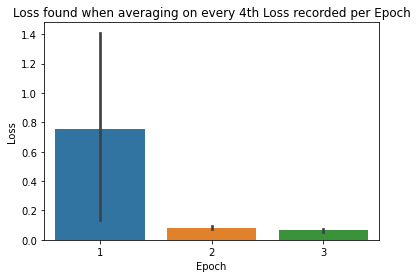

In [50]:
sns.barplot(data=df, x = "Epoch", y = "Loss").set_title("Loss found when averaging on every 4th Loss recorded per Epoch")

print("The black bar represents the Error or in other words the variability of data")

In [98]:
#Accuracy
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(data_loader_val):
        inputs, labels = data
        outputs = net(inputs)
        predicted = labels
        total += labels.size(0)
        label_tensor_maxs = torch.tensor([torch.argmax(x) for x in outputs]) #Used to be labels
        correct += (predicted == label_tensor_maxs).sum().item()

print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))

Accuracy of the network on the test set: 98 %


In [ ]:
#Looking through the validation accuracy values

In [52]:
predicted

tensor([0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2,
        2, 1, 1, 0, 1])

In [53]:
label_tensor_maxs

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

In [95]:
#Labelled as 0
for x in outputs[[0, 1, 4, 9, 13, 20, 21, 22, 27]]:
    print(x.mean())

tensor(0.0056)
tensor(0.0301)
tensor(0.1808)
tensor(0.0090)
tensor(-0.0284)
tensor(0.1535)
tensor(0.0553)
tensor(0.1972)
tensor(0.0754)


In [96]:
#Labelled as 1
for x in outputs[[2, 3, 8, 11, 15, 25, 26, 28]]:
    print(x.mean())

tensor(-0.0827)
tensor(-0.0227)
tensor(-0.0035)
tensor(-0.0895)
tensor(-0.0400)
tensor(-0.0633)
tensor(-0.0078)
tensor(0.0231)


In [97]:
#Labelled as 2
for x in outputs[[5, 6, 7, 10, 12, 14, 16, 17, 18, 19, 23, 24]]:
    print(x.mean())

tensor(0.0345)
tensor(0.0505)
tensor(0.0570)
tensor(0.0893)
tensor(0.0634)
tensor(0.0416)
tensor(0.0248)
tensor(0.0117)
tensor(0.0459)
tensor(0.0349)
tensor(0.0484)
tensor(0.0454)
